In [93]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

import acquire, prepare

### Data Acquisition

In [3]:
df = acquire.get_telco_churn_data()
df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
1,4,1,1,0013-MHZWF,Female,0,No,Yes,9,Yes,...,Yes,Yes,Yes,Yes,69.4,571.45,No,Month-to-month,DSL,Credit card (automatic)
2,1,1,1,0015-UOCOJ,Female,1,No,No,7,Yes,...,No,No,No,Yes,48.2,340.35,No,Month-to-month,DSL,Electronic check
3,1,1,1,0023-HGHWL,Male,1,No,No,1,No,...,No,No,No,Yes,25.1,25.1,Yes,Month-to-month,DSL,Electronic check
4,3,1,1,0032-PGELS,Female,0,Yes,Yes,1,No,...,No,No,No,No,30.5,30.5,Yes,Month-to-month,DSL,Bank transfer (automatic)


### Summarize data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [5]:
df.isnull().sum()

payment_type_id             0
internet_service_type_id    0
contract_type_id            0
customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
paperless_billing           0
monthly_charges             0
total_charges               0
churn                       0
contract_type               0
internet_service_type       0
payment_type                0
dtype: int64

In [6]:
df.nunique()

payment_type_id                4
internet_service_type_id       3
contract_type_id               3
customer_id                 7043
gender                         2
senior_citizen                 2
partner                        2
dependents                     2
tenure                        73
phone_service                  2
multiple_lines                 3
online_security                3
online_backup                  3
device_protection              3
tech_support                   3
streaming_tv                   3
streaming_movies               3
paperless_billing              2
monthly_charges             1585
total_charges               6531
churn                          2
contract_type                  3
internet_service_type          3
payment_type                   4
dtype: int64

In [7]:
df.describe()

,payment_type_id,internet_service_type_id,contract_type_id,senior_citizen,tenure,monthly_charges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,2.315633,1.872923,1.690473,0.162147,32.371149,64.761692
std,1.148907,0.737796,0.833755,0.368612,24.559481,30.090047
min,1.000000,1.000000,1.000000,0.000000,0.000000,18.250000
25%,1.000000,1.000000,1.000000,0.000000,9.000000,35.500000
50%,2.000000,2.000000,1.000000,0.000000,29.000000,70.350000
75%,3.000000,2.000000,2.000000,0.000000,55.000000,89.850000
max,4.000000,3.000000,3.000000,1.000000,72.000000,118.750000


### Plot Distribution of Individual Variables

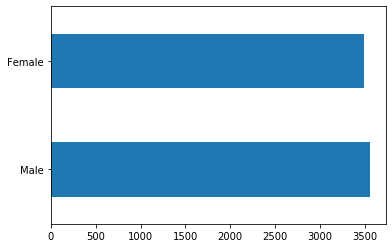

In [8]:
df.gender.value_counts().plot.barh()

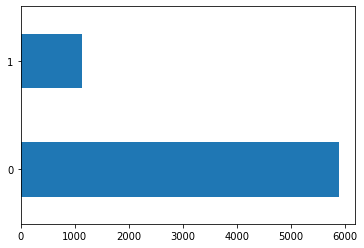

In [9]:
df.senior_citizen.value_counts().plot.barh()

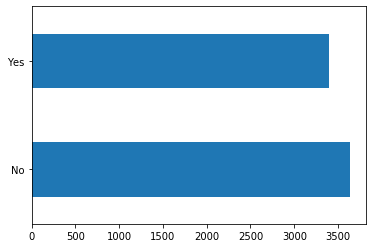

In [10]:
df.partner.value_counts().plot.barh()

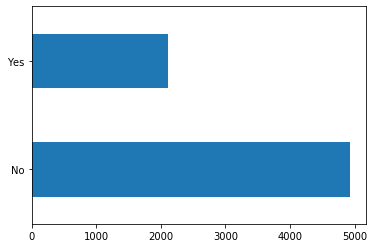

In [11]:
df.dependents.value_counts().plot.barh()

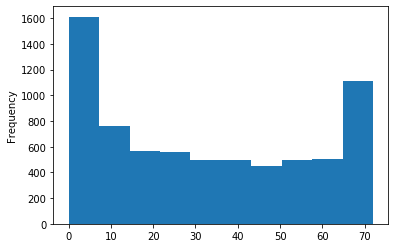

In [12]:
df.tenure.plot.hist()

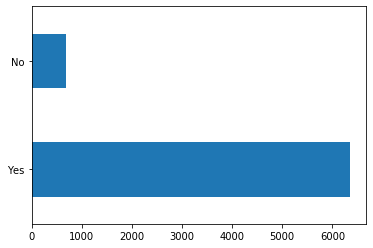

In [13]:
df.phone_service.value_counts().plot.barh()

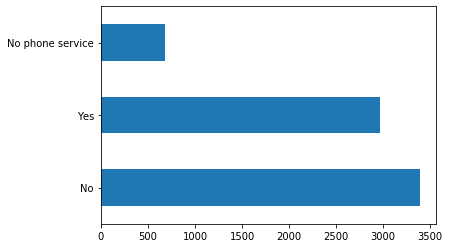

In [14]:
df.multiple_lines.value_counts().plot.barh()

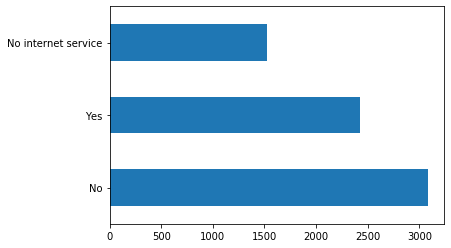

In [15]:
df.online_backup.value_counts().plot.barh()

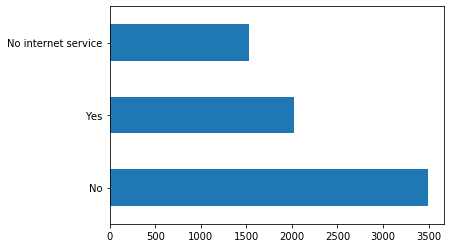

In [16]:
df.online_security.value_counts().plot.barh()

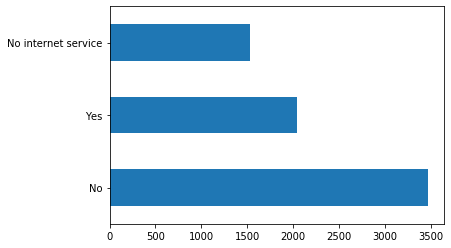

In [17]:
df.tech_support.value_counts().plot.barh()

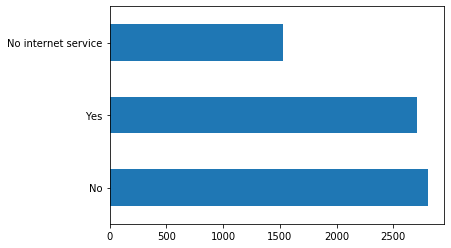

In [18]:
df.streaming_tv.value_counts().plot.barh()

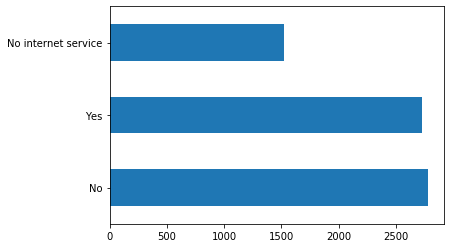

In [19]:
df.streaming_movies.value_counts().plot.barh()

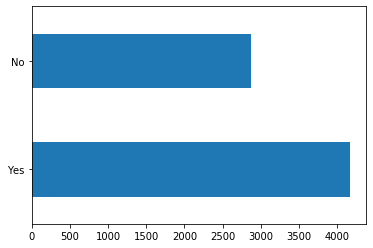

In [20]:
df.paperless_billing.value_counts().plot.barh()

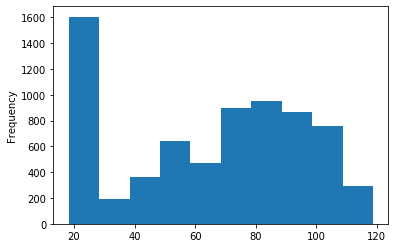

In [21]:
df.monthly_charges.plot.hist()

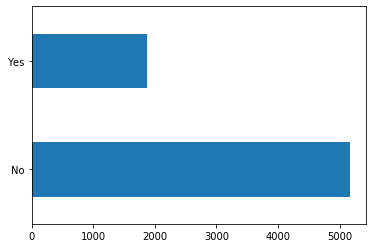

In [22]:
df.churn.value_counts().plot.barh()

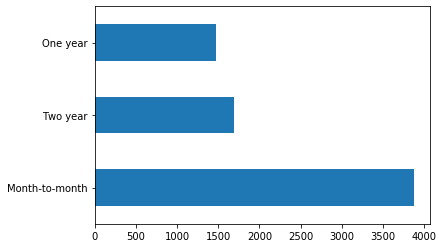

In [23]:
df.contract_type.value_counts().plot.barh()

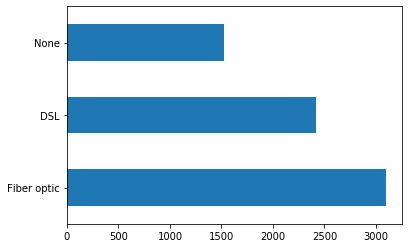

In [24]:
df.internet_service_type.value_counts().plot(kind='barh', )

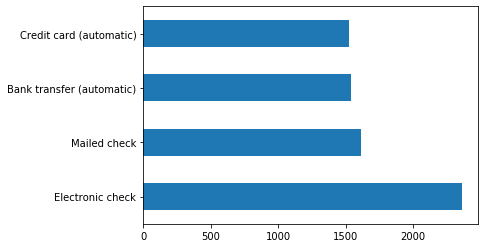

In [25]:
df.payment_type.value_counts().plot.barh()

### Data Preparation

In [27]:
train, validate, test = prepare.prep_telco_churn(df)
train.head()

,senior_citizen,tenure,multiple_lines,device_protection,tech_support,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,partner_dependent,streaming,online_service,tenure_year,Male
5670,0,5,1,0,0,0,20.35,122,0,0,0,1,1,0,0,0.4,1
4152,0,6,1,1,1,1,89.25,487.05,0,0,1,0,0,1,0,0.5,0
4890,0,54,1,1,1,0,84.40,4484.05,0,1,1,0,0,0,1,4.5,1
2391,0,72,1,0,1,0,64.75,4804.75,0,2,1,1,1,0,1,6.0,0
2896,0,28,1,0,1,0,76.55,2065.4,0,0,1,1,1,0,0,2.3,1


In [32]:
train.shape, validate.shape, test.shape

((3943, 17), (1691, 17), (1409, 17))

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3943 entries, 5670 to 6867
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   senior_citizen         3943 non-null   int64  
 1   tenure                 3943 non-null   int64  
 2   multiple_lines         3943 non-null   int64  
 3   device_protection      3943 non-null   int64  
 4   tech_support           3943 non-null   int64  
 5   paperless_billing      3943 non-null   int64  
 6   monthly_charges        3943 non-null   float64
 7   total_charges          3943 non-null   object 
 8   churn                  3943 non-null   int64  
 9   contract_type          3943 non-null   int64  
 10  internet_service_type  3943 non-null   int64  
 11  payment_type           3943 non-null   int64  
 12  partner_dependent      3943 non-null   int64  
 13  streaming              3943 non-null   int64  
 14  online_service         3943 non-null   int64  
 15  t

In [31]:
train.nunique()

senior_citizen              2
tenure                     73
multiple_lines              2
device_protection           2
tech_support                2
paperless_billing           2
monthly_charges          1321
total_charges            3756
churn                       2
contract_type               3
internet_service_type       2
payment_type                2
partner_dependent           2
streaming                   2
online_service              2
tenure_year                61
Male                        2
dtype: int64

### Data Exploration

In [65]:
train.churn.value_counts()

0    2897
1    1046
Name: churn, dtype: int64

Text(0.5, 0, 'Churned')

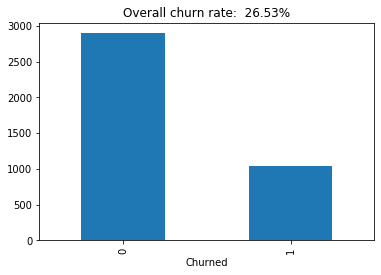

In [66]:
train.churn.value_counts().plot.bar()
churn_rate = train.churn.mean()
plt.title(f"Overall churn rate: {churn_rate: .2%}")
plt.xlabel('Churned')

In [43]:
train.columns.tolist()

['senior_citizen',
 'tenure',
 'multiple_lines',
 'device_protection',
 'tech_support',
 'paperless_billing',
 'monthly_charges',
 'total_charges',
 'churn',
 'contract_type',
 'internet_service_type',
 'payment_type',
 'partner_dependent',
 'streaming',
 'online_service',
 'tenure_year',
 'Male']

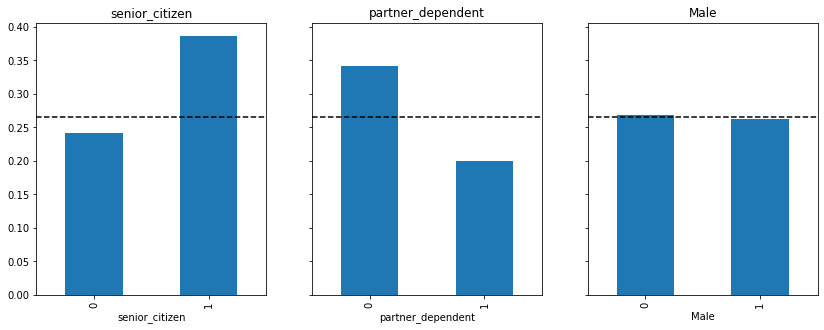

In [68]:
features_1 = ['senior_citizen', 'partner_dependent', 'Male']

n_features = len(features_1)

fig, axs = plt.subplots(1, n_features, figsize=(14,5),sharey=True)

for i, feature in enumerate(features_1):
    train.groupby(feature).churn.mean().plot.bar(ax=axs[i])
    axs[i].set(title=feature)
    axs[i].hlines(churn_rate, *axs[i].get_xlim(), ls='--')

### Are cutomers with partners or/and dependents more loyal than customers without?

$H_0$: There is no significant difference in loyalty between customers with partner or/and dependent and customers without.<br>
$H_a$: There is significant difference in loyalty between customers with partner or/and dependent and customers without.<br>
$\alpha$=0.05

In [108]:
contigency_table = pd.crosstab(train.churn, train.partner_dependent)
contigency_table

partner_dependent,0,1
churn,,
0,1208,1689
1,624,422


In [109]:
chi2, p, degf, expected = stats.chi2_contingency(contigency_table)
p

2.644454950536417e-23

In [110]:
if p/2 < 0.25:
    print('Reject null hypotheis')
elif p/2 > 0.25:
    print('Accept null hypotheis')

Reject null hypotheis


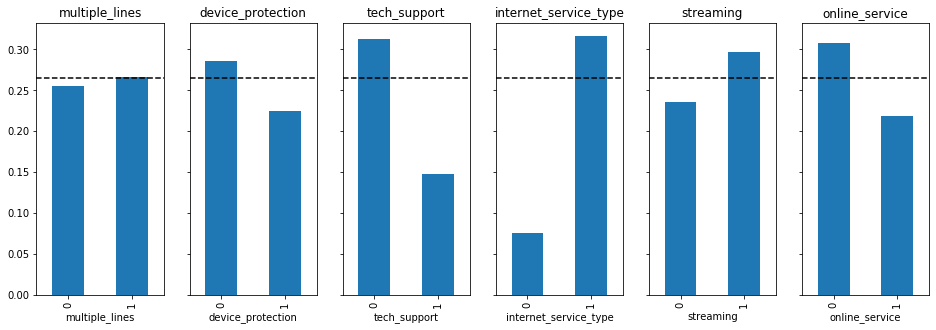

In [69]:
features_2 = ['multiple_lines', 'device_protection', 'tech_support', 
              'internet_service_type', 'streaming', 'online_service']

n_features = len(features_2)

fig, axs = plt.subplots(1, n_features, figsize=(16,5),sharey=True)

for i, feature in enumerate(features_2):
    train.groupby(feature).churn.mean().plot.bar(ax=axs[i])
    axs[i].set(title=feature)
    axs[i].hlines(churn_rate, *axs[i].get_xlim(), ls='--')

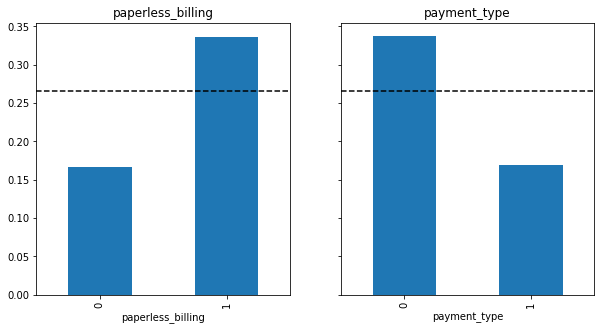

In [76]:
features_3 = ['paperless_billing', 'payment_type']

n_features = len(features_3)

fig, axs = plt.subplots(1, n_features, figsize=(10,5),sharey=True)

for i, feature in enumerate(features_3):
    train.groupby(feature).churn.mean().plot.bar(ax=axs[i])
    axs[i].set(title=feature)
    axs[i].hlines(churn_rate, *axs[i].get_xlim(), ls='--')

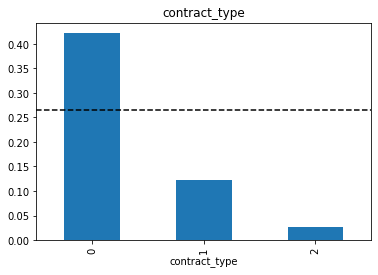

In [73]:
train.groupby('contract_type').churn.mean().plot.bar()
plt.title("contract_type")
plt.hlines(churn_rate, *plt.xlim(), ls='--')

### Is there a difference in monthly charges between the churned and the current? 
$H_0$: The monthly bill of churned customers is no difference than that of customers still in business.<br>
$H_a$: The monthly bill of churned customers is significantly higher than that of customers still in business.<br>
$\alpha$=0.05

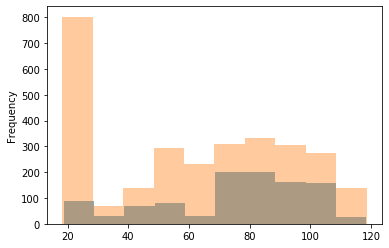

In [98]:
boolean_churned = train.churn == 1
boolean_current = train.churn == 0

monthly_charges_churned = train[boolean_churned].monthly_charges
monthly_charges_current = train[boolean_current].monthly_charges

monthly_charges_churned.plot.hist(alpha=0.6)
monthly_charges_current.plot.hist(alpha=0.4)

In [92]:
train[boolean_churned].monthly_charges.var(), train[boolean_current].monthly_charges.var()

(616.2156527944226, 954.200647414355)

In [101]:
t, p = stats.ttest_ind(monthly_charges_churned, monthly_charges_current, equal_var=False)
t, p

(13.410598855013827, 1.5774458815892836e-39)

In [105]:
if t > 0 and p/2 < 0.5:
    print('Reject null hypotheis')
else:
    print('Accept null hypotheis')

Reject null hypotheis


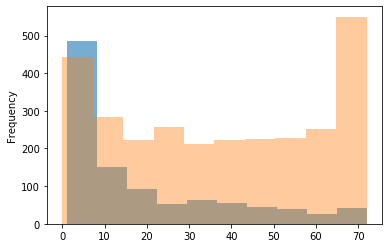

In [106]:
tenure_churned = train[boolean_churned].tenure
tenure_current = train[boolean_current].tenure

tenure_churned.plot.hist(alpha=0.6)
tenure_current.plot.hist(alpha=0.4)

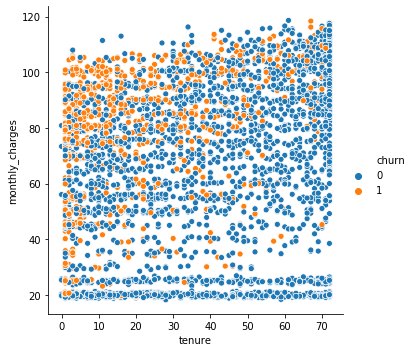

In [80]:
sns.relplot(x='tenure', y='monthly_charges', data=train, hue='churn')